In [91]:
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
import matplotlib.dates as md
import matplotlib.animation as animation

# Do not use automatic offsets for plot axis
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

# Enable interactive plot
%matplotlib notebook

In [92]:
# Load log file from capybot. Set the path to a file capturing the output of the capybot.
file = "../capybot/capybot.log"

def load_data():
    prices = {}
    strategies = {}
    orders = {}
    
    with open(file) as f:
        for line in f:
            try:
                data = json.loads(line)

                if 'msg' not in data:
                    continue

                match data['msg']:
                    case "price":
                        entry = data['price']
                        price = entry['price'];
                        source = entry['source_uri'];
                        if source not in prices:
                            prices[source] = {
                                'offset': entry['price'],
                                'price': [],
                                'time': [],
                            }
                        prices[source]['price'].append(price)
                        prices[source]['time'].append(data['time'] / 1000)

                    # When starting, Capybot outputs all used strategies
                    case "strategies":
                        for strategy in data['strategies']:
                            strategies[strategy] = {};
                            strategies[strategy]['parameters'] = data['strategies'][strategy];
                            strategies[strategy]['statuses'] = {
                                'value': [],
                                'time': []  
                            }

                    case "strategy status":
                        strategy = data['uri']
                        entry = data['data'];
                        strategies[strategy]['statuses']['value'].append(entry)
                        strategies[strategy]['statuses']['time'].append(data['time'] / 1000)

                    case "order":
                        strategy = data['strategy']
                        if strategy not in orders:
                            orders[strategy] = {
                                'time':  [],
                            }
                        orders[strategy]['time'].append(data['time'] / 1000);

                    case _:
                        continue
                     
            except:
                continue
                
    
    return {
        'prices': prices, 
        'strategies': strategies,
        'orders': orders
    } 

In [93]:
# Readable names for pools
pools = {
    '0xcf994611fd4c48e277ce3ffd4d4364c914af2c3cbb05f7bf6facd371de688630': 'Cetus USDC/SUI',
    '0x2e041f3fd93646dcc877f783c1f2b7fa62d30271bdef1f21ef002cebf857bded': 'Cetus CETUS/SUI',
    '0x238f7e4648e62751de29c982cbf639b4225547c31db7bd866982d7d56fc2c7a8': 'Cetus USDC/CETUS',
    '0x5eb2dfcdd1b15d2021328258f6d5ec081e9a0cdcfa9e13a0eaeb9b5f7505ca78': 'Turbos SUI/USDC',
    '0xaa57c66ba6ee8f2219376659f727f2b13d49ead66435aa99f57bb008a64a8042': 'Cetus WBTC/USDC',
}

<IPython.core.display.Javascript object>


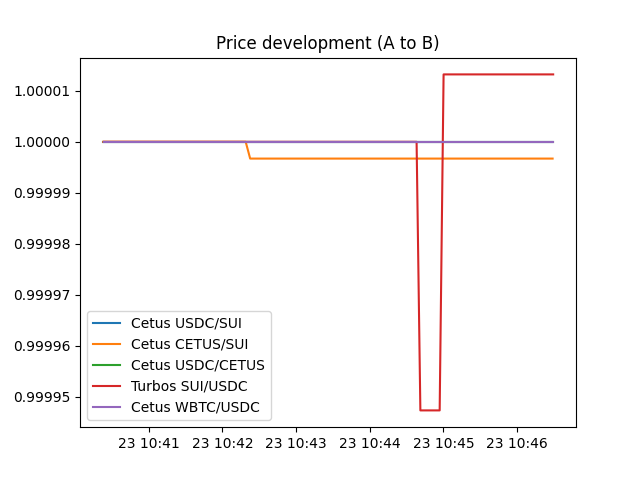

In [99]:
# Plot of prices of all monitored pools
fig, ax = plt.subplots(1,1)

def animate_prices(j):
    data = load_data();
    ax.clear()
    ax.set_title('Price development (A to B)')
    for source in data['prices']:
        prices = data['prices'][source]['price'];
        normalized = np.multiply(prices, 1 / data['prices'][source]['offset'])    
        timestamps = data['prices'][source]['time'];
        dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]
        ax.plot(dates, normalized, label = pools[source])
    ax.legend();

anim1 = animation.FuncAnimation(fig, animate_prices, interval=1000)
fig.show()

<IPython.core.display.Javascript object>


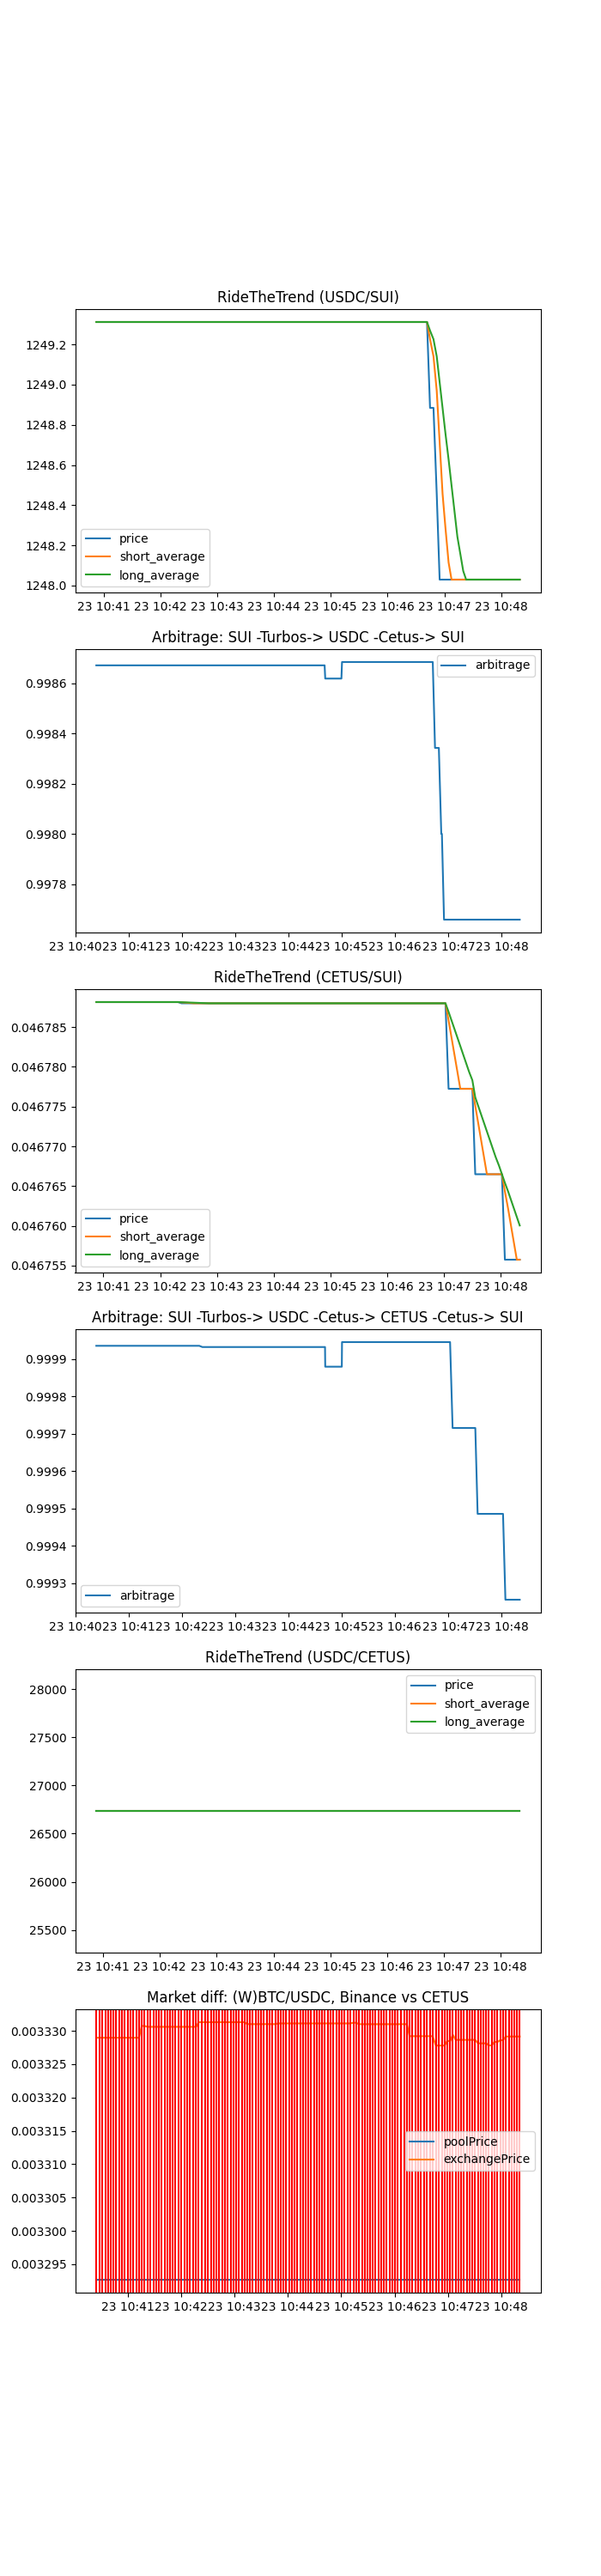

In [101]:
# Plot statuses for all used strategies.
#
# Each strategy may log arbitrary status values and this plots all of them continuously.

# Get the number of strategies first
data = load_data();
number_of_strategies = len(data['strategies']);
fig, ax = plt.subplots(number_of_strategies, 1, figsize = (7, 5 * number_of_strategies));

def animate_strategies(j):
    data = load_data();
    for i, uri in enumerate(data['strategies']):
        strategy = data['strategies'][uri]
        ax[i].clear()
        ax[i].set_title(strategy['parameters']['name'] + "")

        timestamps = strategy['statuses']['time']
        dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]

        if len(strategy['statuses']['value']) == 0:
            break

        for key in strategy['statuses']['value'][0]:
            y = list(map(lambda x: x[key], strategy['statuses']['value']))
            ax[i].plot(dates, y, label = key)
        
        # A trade order is indicated by a vertical red line
        if uri in data['orders']:
            x = [dt.datetime.fromtimestamp(ts) for ts in data['orders'][uri]['time']];
            for xi in x:
                ax[i].axvline(x = xi, color = 'r')
        
        ax[i].legend();    
anim2 = animation.FuncAnimation(fig, animate_strategies, interval=1000)
fig.show()